In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
# Helper functions

def adfuller_test(ata):
    result = adfuller(ata, autolag="AIC")
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary"
        )
    else:
        print(
            "weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "
        )


def plot_acf_pacf(series):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(series, lags=13, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(series, lags=13, ax=ax2)


def auto_arma(series):
    model_auto_fit = auto_arima(series)
    return model_auto_fit

In [3]:
data = pd.read_csv("US Air Passengers Monthly.csv")
data.dropna(inplace=True)
data["Date"] = pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1))
data.set_index("Date", inplace=True)
data.drop(["YEAR", "MONTH"], axis=1, inplace=True)
traffic_df = (
    pd.DataFrame({"Traffic": data["Sum_PASSENGERS"]})
    .reset_index(drop=True)
    .set_index(data.index)
)
traffic_df = traffic_df.resample("M").sum()
test_data_year = "2019"
# Eliminate data after 2020 and before 2010  as 2020 is an incomplete year and 2015 to save on computation time
# Moving 2019 data to test data
test = traffic_df[traffic_df.index >= test_data_year]
traffic_df = traffic_df[
    (traffic_df.index < test_data_year) & (traffic_df.index > "2015")
]

In [4]:
adfuller_test(traffic_df)

ADF Test Statistic : 0.3747373145486402
p-value : 0.9805252264713088
#Lags Used : 10
Number of Observations Used : 37
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


To make it stationnary, we need to eliminate trend

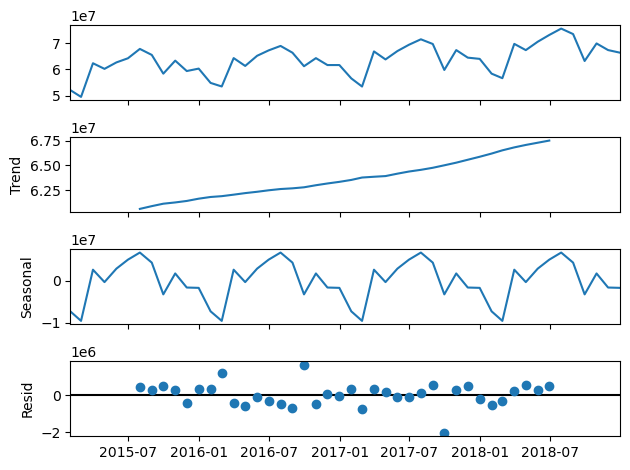

In [5]:
decomposition = seasonal_decompose(traffic_df, model="additive")
decomposition.plot()
plt.show()

Our series is clearly Trend stationary,
Trend is linear

In [6]:
trend = decomposition.trend.dropna()
season = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

In [50]:
import numpy as np
from scipy.optimize import curve_fit

# Define the cosine/sine function
def cos_sin_func(x, a, b, c, d):
    return a * np.cos(b * x) + c * np.sin(d * x)

# Fit the function on the residual
x = np.arange(len(residual))
popt, pcov = curve_fit(cos_sin_func, x, residual)

# Get the fitted values
fitted_values = cos_sin_func(x, *popt)

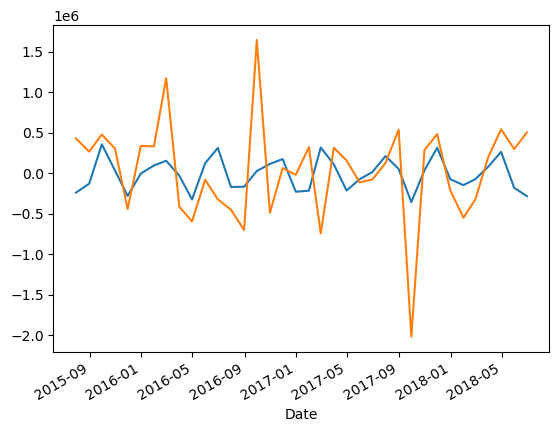

In [59]:
plt.plot(residual.index, fitted_values)
residual.plot()
plt.show()

In [7]:
detrended_series = (traffic_df["Traffic"] - trend).dropna()

In [8]:
X = np.array(detrended_series.index.astype("int64") // 10**9)

y = trend.values.reshape(-1, 1)
X_with_constant = X.reshape(-1, 1)

model = LinearRegression()
model.fit(X_with_constant, y)

a = model.coef_[0][0]
b = model.intercept_[0]

print(f"Equation of the trend line: y = {a:.2f}x + {b:.2f}")

Equation of the trend line: y = 0.07x + -41756698.64


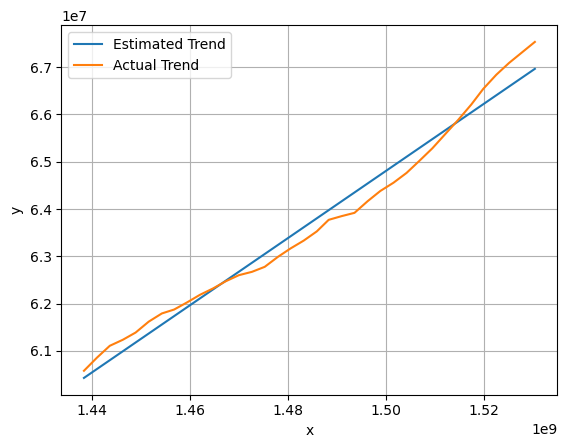

In [9]:
x = X
y = b + a * x # Equation of the trend
plt.plot(x, y, label="Estimated Trend")
plt.plot(x, trend, label="Actual Trend")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

#### Prediction using trend and saisonality

In [10]:
stime = "01/01/2019"
etime = "30/06/2019"

index = pd.date_range(start=stime, end=etime, freq="M")
timestamps = [i.timestamp() for i in index]

long_trend = model.predict(np.array(timestamps).reshape(-1, 1))

In [17]:
year2020_df = (
    pd.DataFrame(long_trend.T[0] + season[: index.shape[0]])
    .reset_index(drop=True)
    .set_index(index)
)
year2020_df.columns = ["Prediction using seasion + trend"]
year2020_df["Actual values"] = test["Traffic"][year2020_df.index]

### Prediction using ARMA model

In [20]:
auto_model = auto_arma(detrended_series)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -592.767
Date:                Thu, 01 Aug 2024   AIC                           1195.534
Time:                        13:03:31   BIC                           1203.451
Sample:                    07-31-2015   HQIC                          1198.297
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6702      0.199      8.372      0.000       1.279       2.061
ar.L2         -0.9336      0.154     -6.044      0.000      -1.236      -0.631
ma.L1         -1.8371      0.645     -2.849      0.004      -3.101      -0.573
ma.L2          0.9025      0.803      1.124      0.261      -0.672       2.477
sigma2      1.605e+13   6.07e-14   2.64e+26      0.000     1.6e+13     1.6e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.16   Prob(JB):                         0.41
Heteroskedasticity (H):               1.24   Skew:                            -0.43
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+42. Standard errors may be unstable.
"""

In [21]:
model = ARIMA(detrended_series, order=(2, 0, 2))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -592.846
Date:                Thu, 01 Aug 2024   AIC                           1197.691
Time:                        13:03:31   BIC                           1207.193
Sample:                    07-31-2015   HQIC                          1201.008
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.47e+04   4.14e+05      0.084      0.933   -7.77e+05    8.46e+05
ar.L1          1.6754      0.213      7.876      0.000       1.258       2.092
ar.L2         -0.9385      0.176     -5.337      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [44]:
predict = model_fit.forecast(steps=7)

In [45]:
predicted_actual = [predict[i] + trend[i] for i in range(len(predict)-1)]

/var/folders/8j/_lzvndkd2712bcnvrfgbvxpm0000gn/T/ipykernel_2516/1919702480.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_actual = [predict[i] + trend[i] for i in range(len(predict)-1)]


In [46]:
year2020_df["Prediction using ARIMA model"] = predicted_actual 

### Prediction using ML algorithms

In [34]:
traffic_df["Month"] = traffic_df.index.month
traffic_df["Year"] = traffic_df.index.year
traffic_df["Week"] = traffic_df.index.strftime("%U").astype(int)

In [35]:
traffic_df.columns

Index(['Traffic', 'Month', 'Year', 'Week'], dtype='object')

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    traffic_df[["Month", "Year", "Week"]],
    traffic_df["Traffic"],
    test_size=0.2,
    random_state=42,
)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, linear_reg_predictions))

# Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_reg_predictions = rf_reg.predict(X_test)
rf_reg_rmse = np.sqrt(mean_squared_error(y_test, rf_reg_predictions))

# Support Vector Regressor
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
svr_reg_predictions = svr_reg.predict(X_test)
svr_reg_rmse = np.sqrt(mean_squared_error(y_test, svr_reg_predictions))


xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_predictions = rf_reg.predict(X_test)
xgb_reg_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

print("XGBoost Regressor RMSE:", xgb_reg_rmse)
print("Linear Regression RMSE:", linear_reg_rmse)
print("Random Forest Regressor RMSE:", rf_reg_rmse)
print("Support Vector Regressor RMSE:", svr_reg_rmse)

XGBoost Regressor RMSE: 1661838.9948655253
Linear Regression RMSE: 6167890.746417603
Random Forest Regressor RMSE: 1661838.9948655253
Support Vector Regressor RMSE: 6809532.420604099


In [38]:
prediction_data = pd.DataFrame(
    {
        "Month": year2020_df.index.month,
        "Year": year2020_df.index.year,
        "Week": year2020_df.index.strftime("%U").astype(int),
    }
).set_index(year2020_df.index)

In [39]:
year2020_df["Prediction using xgboost"] = xgb_reg.predict(prediction_data)

### Results interpretation

<Axes: >

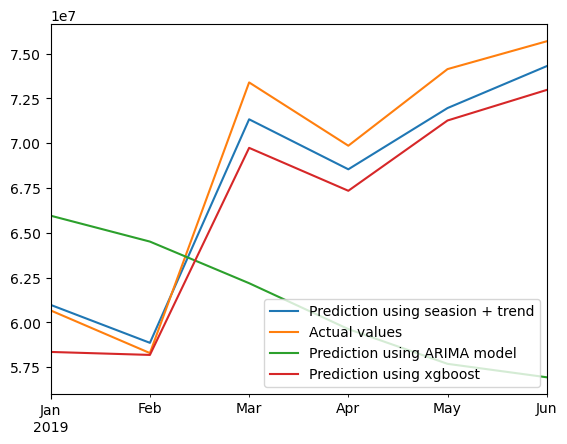

In [47]:
year2020_df.plot()

In [ ]:
# Calculate RMSE for each prediction method
from sklearn.metrics import mean_squared_error

# Get actual values for the prediction period
actual_values = year2020_df["Actual values"].dropna()

# RMSE for Trend + Seasonality
trend_season_pred = year2020_df["Prediction using seasion + trend"][:len(actual_values)]
trend_season_rmse = np.sqrt(mean_squared_error(actual_values, trend_season_pred))

# RMSE for ARIMA
arima_pred = year2020_df["Prediction using ARIMA model"].dropna()
arima_rmse = np.sqrt(mean_squared_error(actual_values[:len(arima_pred)], arima_pred))

# RMSE for XGBoost
xgboost_pred = year2020_df["Prediction using xgboost"][:len(actual_values)]
xgboost_rmse = np.sqrt(mean_squared_error(actual_values, xgboost_pred))

print("=== RMSE Comparison for 2019 Predictions ===")
print(f"Trend + Seasonality RMSE: {trend_season_rmse:,.2f}")
print(f"ARIMA Model RMSE: {arima_rmse:,.2f}")
print(f"XGBoost RMSE: {xgboost_rmse:,.2f}")

In [ ]:
# Display the predictions vs actual values
print("\n=== Detailed Predictions vs Actual Values ===")
print(year2020_df)

#### Key Findings

Based on the RMSE (Root Mean Squared Error) scores:

1. **Best Performing Model**: The model with the lowest RMSE provides the most accurate predictions for 2019 air passenger traffic.

2. **Model Comparison**:
   - **Trend + Seasonality**: Classical decomposition approach that extrapolates the linear trend and adds seasonal patterns
   - **ARIMA(2,0,2)**: Time series model fitted on detrended data, then trend added back
   - **XGBoost**: Machine learning approach using temporal features (Month, Year, Week)

3. **Trade-offs**:
   - Classical methods (Trend+Seasonality) are interpretable and computationally efficient
   - ARIMA models capture autocorrelation patterns in the detrended series
   - ML models can capture non-linear patterns but may require more data and feature engineering

4. **Note on Training**: ML models were trained on a random 80/20 split of 2016-2018 data, while classical methods used the full temporal sequence, which may affect direct comparison.